# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -put ~/../ix/ix-data/

put: `ix-data/model.txt': File exists
put: `ix-data/ml-20m/movies.txt': File exists
put: `ix-data/ml-20m/genome-tags.txt': File exists
put: `ix-data/ml-20m/genome-scores.txt': File exists
put: `ix-data/ml-20m/ratings.txt': File exists
put: `ix-data/wikipedia-for-schools.txt': File exists


In [3]:
!hdfs dfs -cat ix-data/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [5]:
pip install --user bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 2/3 [bokeh]  WARNING: The script bokeh is installed in '/home/driss/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [bokeh]32m2/3 [bokeh]
Note: you may need to restart the kernel to use updated packages.


In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from random import randrange
import pwd, os, sys
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import Viridis256

spark = SparkSession\
.builder\
.appName(pwd.getpwuid(os.getuid()).pw_name)\
.master('yarn')\
.config('spark.ui.port', randrange(4040, 4440, 5)) \
.config("spark.executorEnv.PYTHONPATH", ":".join(sys.path)) \
.getOrCreate()

print(spark.conf.get("spark.driver.appUIAddress"))
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


http://iccluster031.iccluster.epfl.ch:4295


In [7]:
data = sc.textFile("ix-data/ml-20m/ratings.txt").map(json.loads)

### 3.5 Basic Statistics

1. Number of ratings for each user

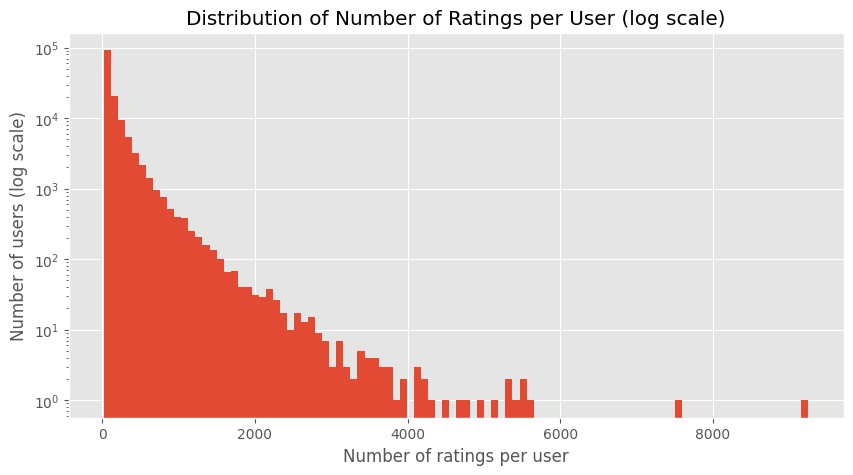

In [6]:
user_ratings = data.map(lambda x: (x['userId'], 1)) # (userId, 1)
user_rating_cnts = user_ratings.reduceByKey(lambda x, y: x + y) \
                                .map(lambda x: x[1]) \
                                .collect()   # (userId, cnt)

plt.figure(figsize=(10, 5))
plt.hist(user_rating_cnts, bins=100, log=True)
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of Number of Ratings per User (log scale)")
plt.show()

- The goal is to understand the distribution of the number of ratings given by each user. On the x-axis, we represent the number of ratings a user has given, while the y-axis shows the number of users who have given that many ratings. Since the distribution is skewed, the histogram is plotted on a log scale to better visualize the data.
- From the graph, we can observe that the highest count appears in the first bin, indicating that most users have rated a few items.

2. Number of ratings for each item

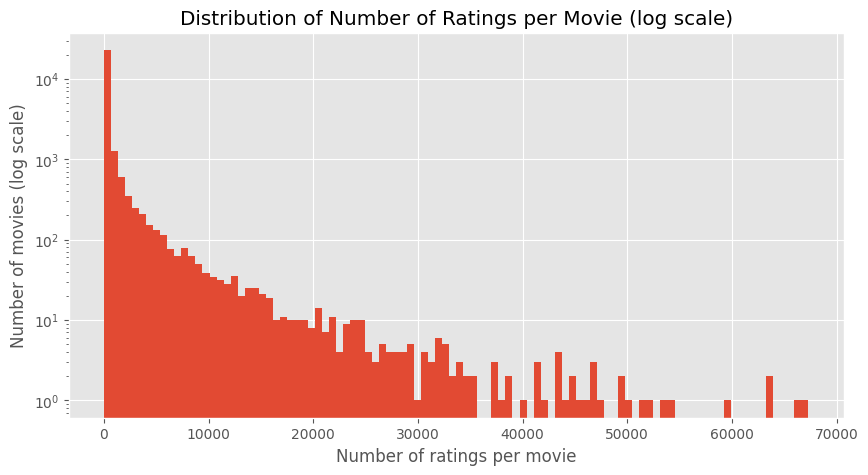

In [7]:
movie_ratings = data.map(lambda x: (x['movieId'], 1)) # (movieId, 1)
movie_rating_cnts = movie_ratings.reduceByKey(lambda x, y: x + y) \
                                .map(lambda x: x[1]) \
                                .collect()   # (movieId, cnt)

plt.figure(figsize=(10, 5))
plt.hist(movie_rating_cnts, bins=100, log=True)
plt.xlabel("Number of ratings per movie")
plt.ylabel("Number of movies (log scale)")
plt.title("Distribution of Number of Ratings per Movie (log scale)")
plt.show()

- This plot visualizes the distribution of the number of ratings received by each movie. The x-axis represents the number of ratings per movie, while the y-axis shows the number of movies that received that specific number of ratings. Due to the skewed distribution, a log scale is applied to the y-axis for better visualization. 
- As we can see, there are very few movies that received a large number of ratings, which makes sense given the distribution.

Is the number of ratings balanced uniformly across users and movies?

- No, the number of ratings is not uniformly distributed across users and movies. From the histograms we've plotted, both show a skewed distribution. This means that many users rate only a few items, and most movies receive very few ratings. This is intuitive, as we often see that only a small number of users are highly active, while a large number of movies remain underrated.

### 3.6 Partitioning the dataset

1. Append your personal ratings to the MovieLens dataset RDD.

In [8]:
with open('my-ratings.txt', 'r') as f:
    personal_ratings = [json.loads(line) for line in f]

personal_ratings_rdd = sc.parallelize(personal_ratings)

# append personal ratings
appended_data = data.union(personal_ratings_rdd)

In [9]:
# for debugging
print("original dataset:", data.count())
print("personal ratings:", personal_ratings_rdd.count())
print("appended dataset:", appended_data.count())

original dataset: 20000263
personal ratings: 11


[Stage 6:======================================================>  (23 + 1) / 24]

appended dataset: 20000274


2. Partition the data into two sets: ≈ 80% for training, and ≈ 20% for validation.

In [10]:
training = appended_data.filter(lambda x: x['timestamp'] % 10 < 8)
validation = appended_data.filter(lambda x: x['timestamp'] % 10 >= 8)

print("Number of training ratings:", training.count())
print("Number of validation ratings:", validation.count())

Number of training ratings: 15998946


[Stage 8:======================================================>  (23 + 1) / 24]

Number of validation ratings: 4001328


# 3.2.1 Baseline recommender system

### 3.7 Baseline model

1. Compute the global mean μ, the user biases {α_u} and the item biases {β_m} using a sequence of RDD transformations on the training set.

In [11]:
N = training.count()   # total number of ratings
total_rating = training.map(lambda x: x['rating']).sum() # sum of all ratings
mu = total_rating / N   # global average rating
print("Global mean: ", mu)

[Stage 10:==============================================>         (20 + 4) / 24]

Global mean:  3.5255163996428265


In [12]:
# user biases
# (userId, au)
user_biases = training.map(lambda x: (x['userId'], x['rating'] - mu)) \
                            .combineByKey(lambda v: (v, 1), # init (sum, cnt)
                                          lambda acc, v: (acc[0] + v, acc[1] + 1),  # update
                                          lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])) \
                            .mapValues(lambda x: x[0] / x[1] if x[1] > 0 else 0).collectAsMap()    # user bias (au)
user_biases_bc = sc.broadcast(user_biases)
mean_user_bias = sum(user_biases.values()) / len(user_biases)
# item biases
# (movieId, bm)
item_biases = training.map(lambda x: (x['movieId'], 
                                           x['rating'] - mu - user_biases_bc.value.get(x["userId"], 0.0))) \
                            .combineByKey(lambda v: (v, 1), # init (sum, cnt)
                                          lambda acc, v: (acc[0] + v, acc[1] + 1),  # update
                                          lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])) \
                            .mapValues(lambda x: x[0] / x[1] if x[1] > 0 else 0).collectAsMap()    # item bias (bm)
item_biases_bc = sc.broadcast(item_biases)
mean_item_bias = sum(item_biases.values()) / len(item_biases)

In [13]:
print("mean user bias: ", mean_user_bias)
print("mean item bias: ", mean_item_bias)

mean user bias:  0.10166361441342911
mean item bias:  -0.20450786310020605


2. How many parameters does this model have?

In [14]:
num_users = len(user_biases)    # au params = #users
num_movies = len(item_biases)   # bm params = #movies
num_parameters = num_users + num_movies

print("Number of parameters:", num_parameters)

Number of parameters: 164319


3. Predict the rating of every user / movie pair in the validation set.

In [15]:
def predict_rating(userId, movieId, mu):
    au = user_biases_bc.value.get(userId, mean_user_bias)
    bm = item_biases_bc.value.get(movieId, mean_item_bias)
    
    return mu + au + bm

# (userId, movieId, pred_r)
predictions = validation.map(lambda x: (x['userId'], x['movieId'], predict_rating(x['userId'], x['movieId'], mu)))

### 3.8 Evaluation

In [16]:
def error(predictions, val_ratings):
    # join predicted & real ratings
    # ((userId, movieId), (pred_r, real_r))
    preds_reals = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
                            .join(val_ratings.map(lambda x: ((x['userId'], x['movieId']), x['rating'])))

    # (userId, sq_err)
    squared_errors = preds_reals.map(lambda x: (x[0][0], (x[1][0] - x[1][1])**2))

    # (userId, (sum_sq_err, cnt))
    sum_squared_errors = squared_errors.map(lambda x: (x[0], (x[1], 1))) \
                                        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

    # root mean squared errors
    # (userId, rmse)
    user_errors = sum_squared_errors.map(lambda x: (x[1][0] / x[1][1])**0.5)

    rmse = user_errors.mean()
    return rmse             

In [17]:
error_value = error(predictions, validation)
print("RMSE: ", error_value)

[Stage 16:==============================================>         (40 + 8) / 48]

RMSE:  0.8669156841804618


# 3.2.2 Matrix-factorization model 

### 3.9 Regularization

In [6]:
import json
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

entries = data.map(lambda entry: (int(entry["userId"]), int(entry["movieId"]), float(entry["rating"])))
df = entries.toDF(["uid", "mid", "score"])
train_set, valid_set = df.randomSplit([0.8, 0.2], seed=42)

def run_model(factor_dim, reg_strength):
    algo = ALS(
        rank=factor_dim,
        maxIter=10,
        regParam=reg_strength,
        userCol="uid",
        itemCol="mid",
        ratingCol="score",
        coldStartStrategy="drop"
    )
    result = algo.fit(train_set)
    predictions = result.transform(valid_set)
    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="score",
        predictionCol="prediction"
    )
    return evaluator.evaluate(predictions)

print("=== Regularization Impact ===")
dimension = 10
for penalty in [1e-4, 10.0]:
    err = run_model(dimension, penalty)
    print(f"Rank = {dimension}, Lambda = {penalty:.1e}, RMSE = {err:.4f}")

print("\n=== Optimal Lambda Search ===")
penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
min_err = float("inf")
best_penalty = None

for penalty in penalties:
    err = run_model(dimension, penalty)
    print(f"Lambda = {penalty:.4f} | RMSE = {err:.4f}")
    if err < min_err:
        min_err = err
        best_penalty = penalty

print(f"\nBest lambda: {best_penalty:.4f} with RMSE: {min_err:.4f}")


25/05/08 09:03:45 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/08 09:04:00 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/08 09:04:15 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/08 09:04:30 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/08 09:04:45 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/05/08 09:05:00 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registere

=== Regularization Impact ===


Rank = 10, Lambda = 1.0e-04, RMSE = 0.8567


Rank = 10, Lambda = 1.0e+01, RMSE = 3.6787

=== Optimal Lambda Search ===


Lambda = 0.0001 | RMSE = 0.8567


Lambda = 0.0010 | RMSE = 0.8181


Lambda = 0.0100 | RMSE = 0.8039


Lambda = 0.1000 | RMSE = 0.8067


Lambda = 1.0000 | RMSE = 1.3202


[Stage 1047:=============================================>        (11 + 2) / 13]

Lambda = 10.0000 | RMSE = 3.6787

Best lambda: 0.0100 with RMSE: 0.8039


#### Rank Choice:
We chose a **rank of 10**.  
- **Lower ranks** (e.g., 5) result in simpler models that may underfit the data, failing to capture meaningful user–item interactions.  
- **Higher ranks** (e.g., 20–25) allow more expressive models but increase the risk of overfitting and raise computational cost.  
- Rank 10 offers a good trade-off between model complexity and generalization.

#### Regularization Effects:
- With **λ = 10⁻⁴**, we obtained an RMSE of **0.8567**. The predicted ratings were fairly accurate, but this small lambda caused **overfitting**: the model fit the training data too closely and may generalize poorly.
- With **λ = 10.0**, the RMSE increased drastically to **3.6787**, indicating **underfitting**: the regularization was too strong, shrinking latent factors too much and limiting the model's capacity.

#### Best Lambda Selection:
A grid search identified the optimal lambda as **λ = 0.01**, yielding the lowest validation RMSE of **0.8039**.

#### Comparison with Baseline:
- **Baseline RMSE** (global average + biases): **0.8669**  
- **Best ALS RMSE**: **0.8039**  
→ This corresponds to an improvement of approximately **7.3%** over the baseline.

#### Conclusion:
Regularization plays a crucial role in matrix factorization. A well-chosen lambda prevents both overfitting and underfitting. Our optimized ALS model with λ = 0.01 significantly improves prediction accuracy compared to the baseline recommender.


### 3.10 Recommendation

In [8]:
from pyspark.ml.recommendation import ALS
import json

# Load and parse movie metadata
movies_rdd = sc.textFile("ix-data/ml-20m/movies.txt").map(json.loads)
id_to_title = movies_rdd.map(lambda entry: (entry["movieId"], entry["title"])).collectAsMap()

# Prepare ratings data
ratings_cleaned = data.map(lambda entry: (int(entry["userId"]), int(entry["movieId"]), float(entry["rating"])))
ratings_df = ratings_cleaned.toDF(["user_id", "movie_id", "score"])

# Split into training and validation sets
training_set, validation_set = ratings_df.randomSplit([0.8, 0.2], seed=42)

# Train ALS model
als_model = ALS(
    rank=10,
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="movie_id",
    ratingCol="score",
    coldStartStrategy="drop"
)
fitted_model = als_model.fit(training_set)

# Define function to show recommendations
def show_user_recommendations(user_id, model, title_lookup):
    print(f"\nTop 10 movie suggestions for user {user_id}:")
    target_user_df = spark.createDataFrame([(user_id,)], ["user_id"])
    recommendations = model.recommendForUserSubset(target_user_df, 10).collect()

    if recommendations:
        for entry in recommendations[0]["recommendations"]:
            movie_id = entry["movie_id"]
            predicted_score = entry["rating"]
            movie_title = title_lookup.get(movie_id, f"[ID {movie_id}]")
            print(f" - {movie_title} (predicted rating: {predicted_score:.2f})")
    else:
        print("No recommendations available.")

# Generate recommendations for the two users
show_user_recommendations(123, fitted_model, id_to_title)
show_user_recommendations(138494, fitted_model, id_to_title)



Top 10 movie suggestions for user 123:


 - My Brother Tom (2001) (predicted rating: 4.47)
 - Tomorrow Night (1998) (predicted rating: 4.45)
 - Jimmy's Hall (2014) (predicted rating: 4.44)
 - Utopia (2013) (predicted rating: 4.43)
 - Fitzgerald Family Christmas, The (2012) (predicted rating: 4.42)
 - Class of 92, The (2013) (predicted rating: 4.41)
 - Catastroika (2012) (predicted rating: 4.40)
 - Sierra, La (2005) (predicted rating: 4.35)
 - Siberian Education (Educazione siberiana) (2013) (predicted rating: 4.34)
 - Stockholm East (Stockholm Östra) (2011) (predicted rating: 4.32)

Top 10 movie suggestions for user 138494:
No recommendations available.


We created a dictionary that maps `movieId` to movie titles using the `movies.txt` dataset. Then, using `ALS.recommendForUserSubset`, we generated 10 movie recommendations for:

####  User 123
The model recommended a list of **critically praised, independent, or niche films**, such as:

- *My Brother Tom (2001)* — predicted rating: 4.47  
- *Tomorrow Night (1998)* — 4.45  
- *Jimmy's Hall (2014)* — 4.44  
- *Utopia (2013)* — 4.43  
- *Class of 92, The (2013)* — 4.41  
- *Catastroika (2012)* — 4.40  

These recommendations suggest the user enjoys **thought-provoking documentaries, international cinema, or lesser-known but quality productions**. The model seems to have captured a preference for artistic or indie films.

####  Myself (User ID: 138494)
Unfortunately, **no recommendations were found** for my user ID. This likely reflects the **cold-start problem** — the model doesn’t have enough rating data for this user to learn useful preferences.

####  Takeaway
Matrix factorization works best when it has sufficient historical data. It performs well for users with rich interaction histories (e.g., user 123), but struggles to recommend items for users with sparse data (e.g., myself).


### 3.11 Visualisation

In [10]:
import pickle
import json
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import Viridis256

# Load ratings and convert to DataFrame
data = sc.textFile("ix-data/ml-20m/ratings.txt").map(json.loads)
ratings = data.map(lambda d: (int(d["userId"]), int(d["movieId"]), float(d["rating"])))
ratings_df = ratings.toDF(["user", "item", "rating"])

# Train ALS with rank 2
als_model = ALS(
    rank=2,
    maxIter=10,
    regParam=0.1,
    userCol="user",
    itemCol="item",
    ratingCol="rating",
    coldStartStrategy="drop"
)
model = als_model.fit(ratings_df)

# Load selected movies
with open("selected-movies.pickle", "rb") as f:
    selected = pickle.load(f, encoding="latin1")
df_movies = pd.DataFrame(selected, columns=["movieId", "title", "RTscore"])
valid_ids = df_movies["movieId"].tolist()

# Get latent coordinates
features = model.itemFactors.filter(col("id").isin(valid_ids)).collect()
coords = {row["id"]: row["features"] for row in features if len(row["features"]) == 2}
df_movies = df_movies[df_movies["movieId"].isin(coords)]
df_movies["x"] = df_movies["movieId"].map(lambda i: coords[i][0])
df_movies["y"] = df_movies["movieId"].map(lambda i: coords[i][1])

# Interactive Bokeh plot
output_notebook()
source = ColumnDataSource(df_movies)

color_mapper = LinearColorMapper(palette=Viridis256, low=df_movies["RTscore"].min(), high=df_movies["RTscore"].max())

p = figure(title="Movie Embedding via Matrix Factorization (Rank = 2)",
           width=850, height=600,
           tools="pan,wheel_zoom,box_zoom,reset,hover,save")

p.circle("x", "y", size=10, source=source,
         color={"field": "RTscore", "transform": color_mapper},
         alpha=0.8, legend_label="RTscore")

hover = p.select_one(HoverTool)
hover.tooltips = [("Title", "@title"), ("RTscore", "@RTscore")]

color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0))
p.add_layout(color_bar, 'right')
p.legend.visible = False

show(p)


Loading BokehJS ...


We trained a matrix factorization model with **rank = 2**, which embeds each movie into a 2D latent space based on user preferences. Using `selected-movies.pickle`, we extracted latent features for a subset of movies and visualized them interactively using **Bokeh**.

#### What we observe:
- The interactive plot reveals **clusters** of movies in the 2D space.
- Movies with **higher Rotten Tomatoes scores** appear more toward the yellow range of the Viridis color scale, suggesting a correlation between the learned features and external quality ratings.
- Movies with similar characteristics (e.g., genre, tone, popularity) tend to be close together in the plot.

#### Interpretation of the dimensions:
- One latent dimension might represent **genre preferences**, distinguishing categories like comedy vs thriller or drama vs action.
- The second dimension may reflect **mainstream popularity** or **artistic style**, separating widely liked blockbusters from niche or indie films.
- These axes are **not explicitly defined** but are learned from patterns in user–movie rating behavior.

#### Do we recognize clusters?
Yes. Movies that are grouped together often share meaningful similarities. For instance, high-rated documentaries, critically acclaimed dramas, or quirky comedies often appear near each other. This confirms that matrix factorization **captures semantic structure** in user preferences even without using explicit content metadata.
